# Sri Lanka Small Tanks Sendimentation Modeling

data source: UNDP small tanks survey

last modified: 2023/12/19

In [1]:
import os
import sys
from hashlib import sha1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier

from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split,
    RandomizedSearchCV,
)

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, KBinsDiscretizer
from sklearn.feature_selection import SelectFromModel

from sklearn.svm import SVC, SVR
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
import shap

## Overview

This analysis embarked on a data-driven journey to predict siltation levels in small tanks, a crucial environmental and agricultural concern, using a robust dataset provided by the UNDP. By recoding siltation depth into a categorical target variable and applying a suite of machine learning models, we sought to understand the intricate dynamics governing siltation. Initial models such as KNN, Ridge, and Logistic Regression offered baseline insights, while advanced ensembles like Random Forest, XGBoost, and LGBM harnessed deeper patterns within the data. Hyperparameter tuning refined the Random Forest model, enhancing its predictive prowess, as evidenced by its superior performance metrics. SHAP values illuminated the influential climatic and geographical factors, guiding targeted interventions. Ultimately, the chosen Random Forest model was deployed on unseen data, delivering actionable predictions that could inform efficient resource allocation for siltation management, with a detailed probability landscape providing a nuanced assessment of model confidence in its predictions.

## Import and split data

The data processing for this analysis begins with a crucial step of recoding the silt column in the tank_df DataFrame into a more analytically suitable format. The column, renamed as Target, originally contains siltation levels described as "less than 1 ft", "1-3 ft", and "more than 3 ft". These textual descriptions are transformed into numerical codes: 0 for "less than 1 ft", 1 for "1-3 ft", and 2 for "more than 3 ft". This recoding is essential for machine learning algorithms, which typically require numerical or categorical inputs. The recoded target variable shows the following distribution: class 2 (0.410205), class 1 (0.401701), and class 0 (0.188095), indicating a somewhat imbalanced dataset, with fewer instances of class 0.

To prepare the dataset for modeling, train_test_split from scikit-learn is utilized to split the data into training and testing sets, with 20% of the data reserved for testing. A crucial aspect of this split is the use of stratification (stratify=tank_df['Target']). Stratification ensures that the proportions of the siltation levels in both the training and testing datasets are representative of the original dataset. This is particularly important in imbalanced datasets, as it prevents scenarios where certain classes are underrepresented in either the training or testing sets. For instance, without stratification, the minority class (class 0) might be underrepresented in the training set, leading to poor model performance on this class.

Post-split, the training data proportion remains nearly identical to the overall distribution with class 2 (0.410270), class 1 (0.401622), and class 0 (0.188108), ensuring that the model learns from a dataset that mirrors the real-world distribution of siltation levels. This alignment of the training set with the overall data characteristics is critical for developing a model that generalizes well and performs consistently when deployed in real-world scenarios, such as for predicting siltation levels in small tanks.

In [2]:
tank_df = pd.read_excel('data/undp_small_tanks_sendimentation_ml.xlsx')
tank_df.head()

,map_id,tank_owner,functional,ndvi201701_1,ndvi201702_1,ndvi201703_1,ndvi201704_1,ndvi201705_1,ndvi201706_1,ndvi201707_1,...,has_2_func_sluice,has_spill,has_2_spill,silt,poly,no_neighbors,cascade,renovat,num_slu,soil
0,18,DAD,Functioning,7642.616211,6110.480469,5189.187988,5033.489258,5853.970703,6491.962891,5696.561035,...,0,1,0,less than 1 ft,1,1.0,0.0,0.0,1,"Noncalcic Brown soils, soils on old alluvium &..."
1,25,DAD,Functioning,7218.720215,6200.347656,4881.518555,4558.301270,4658.052734,5147.490234,5143.641113,...,0,1,0,less than 1 ft,1,16.0,0.0,0.0,1,Noncalcic Brown soils & Low Humic Gley soils; ...
2,26,DAD,Functioning,7026.510742,6043.844238,4861.998047,4527.718262,4617.099121,5060.282227,5067.521484,...,0,1,0,less than 1 ft,1,17.0,0.0,0.0,1,Noncalcic Brown soils & Low Humic Gley soils; ...
3,28,DAD,Functioning,6575.861328,5811.095703,5302.811523,5144.025879,5558.791016,5985.856445,5473.228516,...,0,1,0,less than 1 ft,1,8.0,0.0,0.0,0,Regosols on Recent beach and dune sands; flat ...
4,122,DAD,Functioning,7861.033203,7740.585449,6765.989258,6530.480469,6500.167969,6573.558105,6044.023438,...,1,1,0,more than 3 ft,1,3.0,0.0,1.0,2,Reddish Brown Earths & Low Humic Gley soils; u...


In [3]:
tank_df = tank_df.rename(columns={'silt': 'Target'})

target_mapping = {
    "less than 1 ft": 0,
    "1-3 ft": 1,
    "more than 3 ft": 2
}

tank_df['Target'] = tank_df['Target'].replace(target_mapping)
tank_df['Target'].value_counts(normalize=True)

Target
2    0.410205
1    0.401701
0    0.188095
Name: proportion, dtype: float64

In [4]:
train_df, test_df = train_test_split(tank_df, test_size=0.2, random_state=123, stratify=tank_df['Target'])
train_df.shape, test_df.shape

((5550, 78), (1388, 78))

In [5]:
train_df["Target"].value_counts(normalize=True)

Target
2    0.410270
1    0.401622
0    0.188108
Name: proportion, dtype: float64

## Preprocessing and metrics selection

The dataset utilized in this study originates from the UNDP's small tank database, which includes comprehensive siltation information derived from a spatial join with a national database. This data is instrumental in assessing the level of sedimentation within small tanks across Sri Lanka, with siltation levels categorized by the depth of sediment accumulation measured in feet. Predictors encompass a range of attributes, including tank utilization, condition, surrounding environmental characteristics, and weather metrics. Monthly aggregated data, such as NDVI, precipitation, and temperature, are obtained from high-resolution satellite imagery, ensuring precise and up-to-date information. Additional categorical and binary features provide insights into land cover, soil types, aquifer characteristics, and tank functionality. This rich dataset serves as a foundation for developing machine learning models aimed at predicting siltation levels, ultimately aiding in the effective management and maintenance of these critical water resources.

### Data Description

| Variable Group | Variable Name | Type/Resolution | Description | Source |
|----------------|---------------|-----------------|-------------|--------|
| **Dependent Variable** | Siltation | Categorical | The level of siltation categorized by the depth of sediment accumulation, measured in feet. | UNDP small tank database |
| **Numeric Features** | Monthly NDVI, Precipitation, Temperature (e.g., `ndvi201701_1`) | ~100m | Monthly mean values derived from a 2 km buffer zone of tanks for each month in 2017. | MODIS/Terra Vegetation Indices, CHIRPS 2.0, MODIS-Terra LST |
|  | Aggregated Weather Metrics (e.g., `chirps_mean`) | ~100m | Mean and standard deviation of monthly weather metrics across the year. | CHIRPS 2.0, MODIS-Terra LST |
|  | Coefficient of Variation (e.g., `chirps_cv`) | ~100m | Variability of weather metrics relative to their mean value. | CHIRPS 2.0, MODIS-Terra LST |
|  | Water Surface Area (`wsa`), Slope (`slope_dem_1`) | Continuous, 30m | Water surface area of the tank and the slope of the terrain surrounding the tank. | UNDP small tank survey, SRTM 30m (NASA, NGA) |
|  | Groundwater Risk (`gw_risk`), Neighbors (`no_neighbors`) | Continuous | Metrics assessing the groundwater risk and the count of nearby tanks. | UNDP small tank database |
| **Binary Features** | Tank Usage and Condition (e.g., `_4_1irrigatedagriculture`) | Binary | Indicators of tank usage for irrigation, fishing, etc., and its condition like breached or renovated. | UNDP small tank survey database |
|  | Cascade System (`cascade`), Renovation (`renovat`) | Binary | Indicators of the tank being part of a cascade system and recent renovations. | UNDP small tank survey database |
| **Categorical Features** | Soil Type (`soil`), Aquifer Name (`aquname`) | Categorical | Variables describing soil type, aquifer characteristics. | UNDP small tank survey database, Sham |
|  | Aquifer Type (`aquifer`), Tank Ownership (`tank_ownership`) | Categorical | Characteristics of the aquifer, ownership details of the tanks. | UNDP small tank survey database |
|  | Functional Use (`functional`) | Categorical | The functional use of the tanks. | UNDP small tank survey database |
| **Ordinal Features** | Number of Functional Sluices (`num_slu`) | Ordinal | An ordered feature indicating the number of functional sluices. | UNDP small tank survey database |
| **Features to Drop** | Administrative Info (e.g., `map_id`) | - | Non-predictive administrative details. | UNDP small tank survey database |


### Data Preprocessing

In the preprocessing stage of the machine learning pipeline, each category of features is treated appropriately to ensure optimal model performance and to address any potential data issues. This preprocessing step is crucial as it directly impacts the quality of the model's predictions.

For the numeric features, a two-step process is employed: Firstly, missing values are handled using SimpleImputer with a strategy to replace missing entries with the median of the respective feature. The median is a robust measure of central tendency, especially useful in the presence of outliers, as it is less affected by extreme values compared to the mean. Secondly, StandardScaler is used to standardize these features. Standardization involves rescaling the features so that they have a mean of zero and a standard deviation of one. This is important because it neutralizes the scale differences among features, allowing models, particularly those sensitive to feature scaling like Support Vector Machines and k-Nearest Neighbors, to converge faster and perform more effectively.

For categorical and binary features, missing values are imputed using the most frequent value, which is a common approach for discrete data, ensuring that the mode of the dataset is used as the replacement strategy. Then, OneHotEncoder is applied, converting these features into a format that can be easily interpreted by the machine learning algorithms. One-hot encoding transforms categorical data into a binary matrix, which is particularly useful for models that require numerical input. By encoding these variables, we preserve the categorical information without imposing arbitrary ordinality.

The ordinal features undergo a similar imputation for missing values. The OrdinalEncoder is then used, which is suitable for features with a natural ordered relationship between the values. Encoding ordinal features correctly ensures that the model can interpret the inherent order in these variables, which might be crucial for accurate predictions.

Lastly, certain features are dropped from the model. This step is essential to remove irrelevant or redundant data that could otherwise lead to overfitting or skew the model's performance. By carefully selecting the most relevant features, we enhance the model's ability to generalize and make accurate predictions on new, unseen data.

### Evaluation Metrics

In the context of predicting the siltation levels of small tanks, the chosen evaluation metrics – accuracy, macro-averaged precision, recall, and F1-score – offer a comprehensive picture of the model's performance, catering to the intricacies of a multi-class classification problem with a potentially imbalanced dataset.

Accuracy is the most intuitive metric, representing the proportion of correctly predicted instances out of all predictions. In a real-world scenario, a high accuracy means that the model is generally reliable in identifying the siltation levels of tanks. For resource allocation, this translates to an efficient first-pass filter in identifying tanks at various siltation levels, which is crucial for large-scale, preliminary assessments.

However, accuracy alone can be misleading, especially if the dataset is imbalanced (i.e., some classes of siltation levels are more prevalent than others). This is where precision and recall come into play, and their macro-averaged versions ensure that each class is equally weighted, regardless of its frequency in the dataset. Precision (the proportion of true positives among all positive predictions) is critical in minimizing false alarms – situations where a tank is incorrectly flagged for having a severe siltation problem. High precision ensures that resources are not wastefully allocated to tanks that do not require immediate intervention. On the other hand, recall (the proportion of true positives among all actual positives) is vital for minimizing missed cases – failing to identify tanks that do indeed have severe siltation. In resource allocation terms, high recall ensures that most tanks needing attention are correctly identified and prioritized.

The F1-score, being the harmonic mean of precision and recall, balances these two metrics. A high F1-score in a macro-averaged setting indicates a model that is not only accurate but also equally adept at handling all classes, a desirable quality for equitable resource distribution. This ensures that smaller or less noticeable tanks – which might be critical in their local contexts – are not overshadowed by larger or more prominent ones.

In practical terms, these metrics together guide the development of a predictive model that is robust, fair, and effective in the allocation of resources for tank maintenance and siltation management. By prioritizing tanks accurately classified as having severe siltation issues, authorities can optimize their intervention strategies, focusing efforts and resources where they are needed most, thus ensuring the sustainability and functionality of these crucial water resources.

In [7]:
X_train = train_df.drop(columns=['Target'])
y_train = train_df['Target']
X_test = test_df.drop(columns=['Target'])
y_test = test_df['Target']

In [8]:
numeric_features = ['ndvi201701_1', 'ndvi201702_1', 'ndvi201703_1', 'ndvi201704_1', 'ndvi201705_1', 'ndvi201706_1',
                   'ndvi201707_1', 'ndvi201708_1', 'ndvi201709_1', 'ndvi201710_1', 'ndvi201711_1', 'ndvi201712_1', 
                   'chirps201701_1', 'chirps201702_1', 'chirps201703_1', 'chirps201704_1', 'chirps201705_1', 'chirps201706_1',
                   'chirps201707_1', 'chirps201708_1', 'chirps201709_1', 'chirps2017010_1', 'chirps201711_1', 'chirps201712_1',
                   'lst201701_1', 'lst201702_1', 'lst201703_1', 'lst201704_1', 'lst201705_1', 'lst201706_1',
                   'lst201707_1', 'lst201708_1', 'lst201709_1', 'lst201710_1', 'lst201711_1', 'lst201712_1',
                   'chirps_mean', 'chirps_std', 'lst_mean', 'lst_std', 'ndvi_mean', 'ndvi_std', 
                   'chirps_cv', 'lst_cv', 'ndvi_cv', 
                   'wsa', 'slope_dem_1','gw_risk', 'no_neighbors']

binary_features = ['_4_1irrigatedagriculture', '_4_2fishing', '_4_3livestock', '_4_4daytodayuse', '_4_5smallscaleindustries', '_4_6environmentaluse', '_4_7ecotourism', '_4_8other',
                   '_5_2_1breached', '_5_2_1_1needrenovations', '_5_2_2goodcondition', '_5_2_3tankbundrehabilitated',
                   'has_func_sluice', 'has_2_func_sluice', 'has_spill', 'has_2_spill', 'poly', 'cascade', 'renovat']

categorical_features = ['soil', 'aquname', 'aquifer', 'tank_ownership', 'functional']

ordinal_features = ['num_slu']

drop_features = ['map_id', 'tank_owner', '_6numberoffunctionalsluices']

In [9]:
print(len(numeric_features) + len(binary_features) + len(categorical_features) + len(drop_features))

76


In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int, drop="if_binary"))
        ]), categorical_features + binary_features),

        ("ord", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OrdinalEncoder(dtype=np.int64, handle_unknown='use_encoded_value', unknown_value=-1))
        ]), ordinal_features),
        ("drop", 'drop', drop_features)
    ]
)

In [11]:
preprocessor.fit(X_train, y_train)
onehot_feature_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features + binary_features)

feature_names = (
    numeric_features
    + ordinal_features
    + preprocessor.named_transformers_['cat']['encoder']
    .get_feature_names_out(categorical_features + binary_features)
    .tolist()
)

In [6]:
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro'),
}


In [12]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

results = {}

## Modeling

### Baselines

The selection of the Dummy Classifier, a Decision Tree with a maximum depth of 3, and Logistic Regression (multinomial for multi-class targets) as baseline models (with imbalanceness taken into consideration) in this analysis is a strategic choice, aimed at establishing a foundational performance benchmark and understanding the complexity needed for accurate predictions.

Dummy Classifier serves as the most basic baseline, essentially providing the "no-skill" level of prediction. In machine learning, this model makes predictions using simple rules, which can be random or based on the most frequent class. The purpose of using a Dummy Classifier is to set a minimum performance threshold; any meaningful model should outperform this baseline. It's essential in highlighting the bare minimum that needs to be achieved to consider any advanced model useful for the task at hand.

Decision Tree Classifier, limited to a maximum depth of 3, is a simple yet effective model. Decision trees split the data based on the values of the features, making them easy to interpret and understand. Limiting the tree's depth ensures that the model remains simple and prevents overfitting. In this context, a shallow decision tree acts as a baseline to assess whether a basic, interpretable model can capture the necessary patterns in the data for predicting siltation levels. It provides a balance between simplicity and the ability to handle nonlinear relationships.

Logistic Regression is a more sophisticated model compared to the first two, especially when configured for multi-class targets (multinomial). It predicts probabilities of the different classes and is a strong baseline for classification problems. This model assumes a linear relationship between the log-odds of the probabilities and the features. By using it in a multinomial setting, it's possible to assess whether the relationships in the data are linear and if a linear model is sufficient to capture the underlying patterns for the prediction task.

Together, these baselines cover a spectrum from the most simplistic to moderately complex models in machine learning. They provide a comprehensive starting point for evaluating more complex models – any advanced model should not only outperform the Dummy Classifier but also show significant improvement over the Decision Tree and Logistic Regression to justify its complexity. This approach ensures that the final chosen model strikes an appropriate balance between accuracy, complexity, and interpretability in predicting the siltation levels of small tanks.

In [13]:
dummy = DummyClassifier(strategy="stratified")
results["dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)
pd.DataFrame(results)

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


,dummy
fit_time,0.002 (+/- 0.001)
score_time,0.006 (+/- 0.001)
test_accuracy,0.361 (+/- 0.006)
train_accuracy,0.367 (+/- 0.007)
test_precision_macro,0.330 (+/- 0.011)
train_precision_macro,0.335 (+/- 0.008)
test_recall_macro,0.331 (+/- 0.011)
train_recall_macro,0.335 (+/- 0.008)
test_f1_macro,0.330 (+/- 0.011)
train_f1_macro,0.335 (+/- 0.008)


In [14]:
pipe_dt = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(random_state=123, class_weight='balanced', max_depth=3)
)

# Get cross-validation scores for the decision tree
results["decision_tree"] = mean_std_cross_val_scores(
    pipe_dt, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)
pd.DataFrame(results)

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


,dummy,decision_tree
fit_time,0.002 (+/- 0.001),0.232 (+/- 0.025)
score_time,0.006 (+/- 0.001),0.016 (+/- 0.003)
test_accuracy,0.361 (+/- 0.006),0.444 (+/- 0.020)
train_accuracy,0.367 (+/- 0.007),0.458 (+/- 0.007)
test_precision_macro,0.330 (+/- 0.011),0.519 (+/- 0.030)
train_precision_macro,0.335 (+/- 0.008),0.543 (+/- 0.027)
test_recall_macro,0.331 (+/- 0.011),0.485 (+/- 0.021)
train_recall_macro,0.335 (+/- 0.008),0.500 (+/- 0.004)
test_f1_macro,0.330 (+/- 0.011),0.413 (+/- 0.028)
train_f1_macro,0.335 (+/- 0.008),0.426 (+/- 0.011)


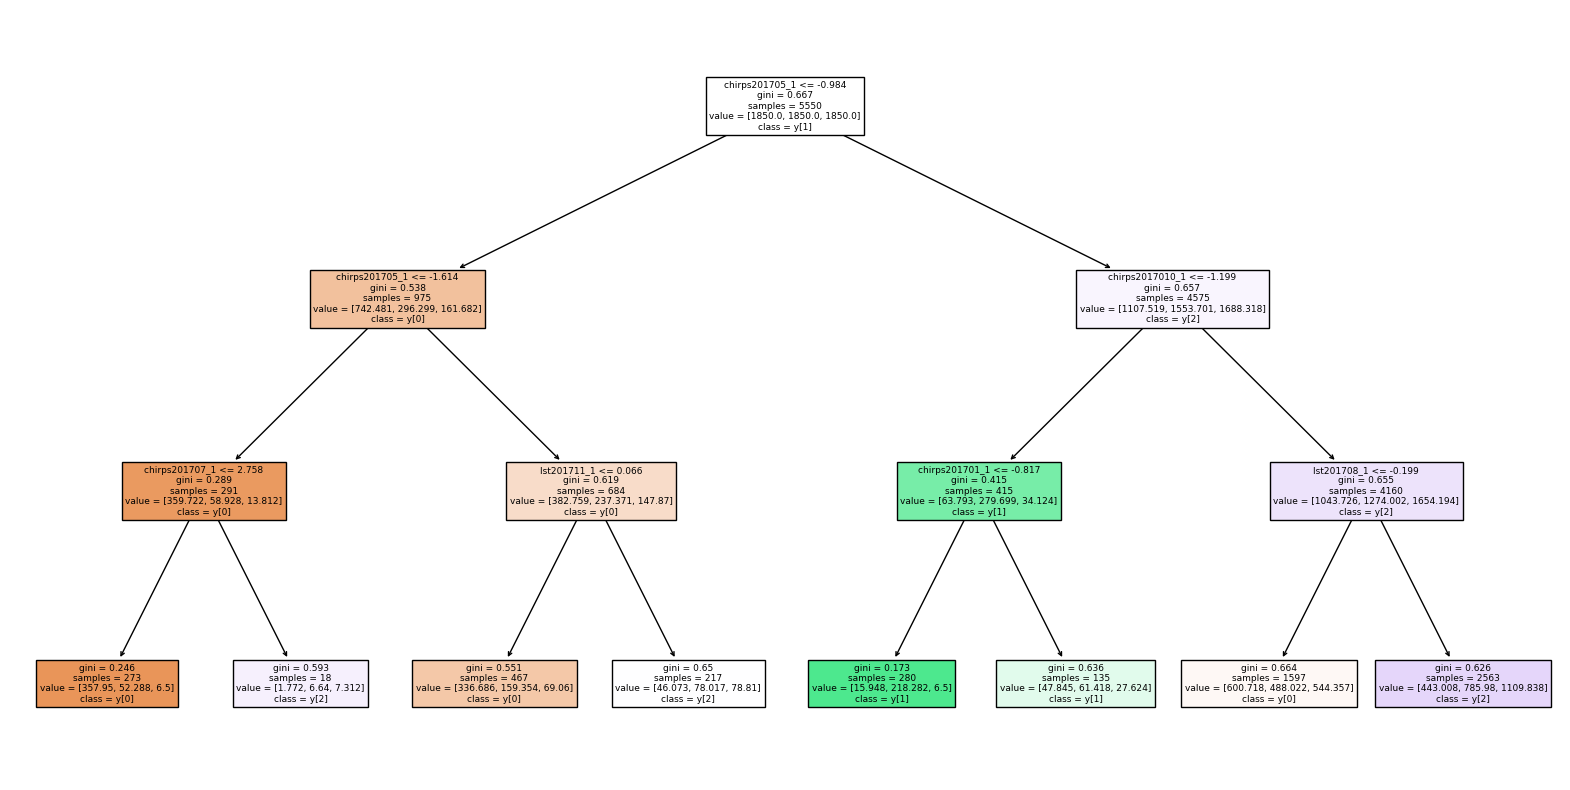

In [15]:
pipe_dt.fit(X_train, y_train)

# Get the fitted decision tree classifier from the pipeline
fitted_tree = pipe_dt.named_steps['decisiontreeclassifier']

# Plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(fitted_tree, filled=True, feature_names=feature_names, class_names=True)
plt.show()

In [16]:
pipe_lr = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter=2000, random_state=123, class_weight="balanced", multi_class='multinomial', solver='lbfgs')
)

results["logreg"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)

pd.DataFrame(results)

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


,dummy,decision_tree,logreg
fit_time,0.002 (+/- 0.001),0.232 (+/- 0.025),0.495 (+/- 0.036)
score_time,0.006 (+/- 0.001),0.016 (+/- 0.003),0.018 (+/- 0.000)
test_accuracy,0.361 (+/- 0.006),0.444 (+/- 0.020),0.502 (+/- 0.015)
train_accuracy,0.367 (+/- 0.007),0.458 (+/- 0.007),0.532 (+/- 0.006)
test_precision_macro,0.330 (+/- 0.011),0.519 (+/- 0.030),0.493 (+/- 0.017)
train_precision_macro,0.335 (+/- 0.008),0.543 (+/- 0.027),0.526 (+/- 0.006)
test_recall_macro,0.331 (+/- 0.011),0.485 (+/- 0.021),0.509 (+/- 0.019)
train_recall_macro,0.335 (+/- 0.008),0.500 (+/- 0.004),0.544 (+/- 0.005)
test_f1_macro,0.330 (+/- 0.011),0.413 (+/- 0.028),0.490 (+/- 0.017)
train_f1_macro,0.335 (+/- 0.008),0.426 (+/- 0.011),0.522 (+/- 0.006)


#### Cross-Validation Results

The cross validation results of the three baseline models – the Dummy Classifier, Decision Tree (with a maximum depth of 3), and Logistic Regression (multinomial) – provide insightful benchmarks for predicting siltation levels in small tanks. Each model exhibits distinct performance characteristics in terms of accuracy, precision, recall, and F1-score, both on the training and test sets.

_Dummy Classifier:_

- Accuracy: With a test accuracy of around 0.361, the Dummy Classifier performs as expected for a model with no predictive power. Its role is to set a baseline; any meaningful model should surpass this level of accuracy.

- Precision, Recall, F1-score: The macro-averaged precision, recall, and F1-score are all around 0.33, which aligns with the expectation of a model that classifies randomly. The similarity in these scores confirms the model's lack of discriminative power.

_Decision Tree:_

- Accuracy: The Decision Tree shows a noticeable improvement over the Dummy Classifier, with a test accuracy of approximately 0.444. This indicates that even a simple model with limited depth can capture some relationships in the data.
Precision, Recall, F1-score: The precision (0.519) is significantly higher than the Dummy Classifier, suggesting better discriminative ability, though the recall (0.485) and F1-score (0.413) indicate there is still room for improvement. This model likely captures some key patterns in the data but also misses others.

_Logistic Regression:_

- Accuracy: The Logistic Regression further improves on the Decision Tree, with a test accuracy of about 0.502. This suggests that the relationships in the data have some linear components which this model is capturing.

- Precision, Recall, F1-score: The precision (0.493) and recall (0.509) are fairly balanced, resulting in an F1-score (0.490) that is the highest among the baseline models. This balance indicates a reasonable trade-off between the proportion of correct positive predictions and the model's ability to identify positive instances.

In the context of small tank siltation levels, these results suggest that simple models can provide some insight into the factors influencing siltation, but there is complexity in the data that these models are not fully capturing. The Logistic Regression model, in particular, shows promise and indicates that a linear approach has some validity. However, the modest scores across all metrics suggest that more sophisticated models or feature engineering might be necessary to achieve high predictive performance.

For practical implementation, such as optimizing resource allocation for tank maintenance, these models provide a starting point. The Decision Tree, with its interpretability, could offer some initial insights, while the Logistic Regression model's slightly better performance might inform more nuanced strategies. However, given the moderate scores, reliance solely on these models for decision-making should be approached with caution. Advanced models, or a combination of models, might be necessary to ensure accurate and reliable predictions for effective resource allocation.

In [17]:
pipe_lr.fit(X_train, y_train)

# Make predictions
y_pred = pipe_lr.predict(X_test)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

Confusion Matrix:
 [[148  44  69]
 [130 201 227]
 [109 106 354]]

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.57      0.46       261
           1       0.57      0.36      0.44       558
           2       0.54      0.62      0.58       569

    accuracy                           0.51      1388
   macro avg       0.50      0.52      0.49      1388
weighted avg       0.53      0.51      0.50      1388



#### Initial Perfomance on Test Data

The confusion matrix and classification report for the logistic regression model reveal insights into its performance in predicting siltation levels in small tanks, categorized as 0 ("less than 1 ft"), 1 ("1-3 ft"), and 2 ("more than 3 ft").

_Confusion Matrix Analysis:_

- Class 0 (less than 1 ft): Out of the 261 true instances, the model correctly predicted 148 as class 0, but it incorrectly classified 44 as class 1 and 69 as class 2. The model shows a relatively higher tendency to predict class 0 correctly compared to the other classes.

- Class 1 (1-3 ft): The model seems to struggle with this class. Out of 558 instances, only 201 are correctly classified. A significant number of instances (130) are misclassified as class 0, and 227 are misclassified as class 2.

- Class 2 (more than 3 ft): This class has the highest number of correct predictions (354 out of 569), indicating better performance by the model for this class. However, there are still notable misclassifications, with 109 instances predicted as class 0 and 106 as class 1.

_Classification Report Analysis:_

- Precision: The model has the highest precision for class 1 (0.57), meaning it is relatively more reliable when it predicts an instance as class 1. However, its precision is lower for class 0 (0.38) and class 2 (0.54).

- Recall: The recall is highest for class 2 (0.62), indicating that the model is better at identifying true instances of class 2 than other classes. Class 0 has a recall of 0.57, and class 1 has the lowest recall of 0.36.

- F1-Score: The F1-score, which balances precision and recall, is highest for class 2 (0.58), followed by class 0 (0.46) and class 1 (0.44). This suggests that, overall, the model performs best in identifying class 2.

- Accuracy: The overall accuracy of the model is 0.51, indicating that it correctly predicts the siltation level about half of the time across all classes.

_Real-world Implications:_

The model demonstrates moderate effectiveness, with a tendency to perform better in predicting higher siltation levels (class 2).
The lower performance in class 1 might indicate challenges in differentiating between moderate and extreme siltation levels.
In practical terms, while the model can be useful in identifying tanks with more severe siltation (which could be prioritized for maintenance), its limitations in accurately classifying all siltation levels suggest a need for additional models or strategies to improve decision-making in resource allocation.
The model's moderate overall accuracy and imbalanced performance across classes imply that relying solely on this model for critical decisions could lead to misallocation of resources or missed opportunities for intervention in tanks with less severe siltation levels.

### Model Exploration: KNN, Ridge, Random Forst, XGBoost (Technical notes)

In this analysis, a variety of machine learning models are further explored, each with unique characteristics and strengths, making them suitable for predicting siltation levels in small tanks.

- Support Vector Machine (SVM): SVM is a powerful and versatile supervised learning algorithm used for both classification and regression tasks. It works by finding the hyperplane that best separates different classes in the feature space. For classification, such as in this analysis, it identifies the plane that maximizes the margin between different classes. SVM is effective in high-dimensional spaces and with datasets where classes are distinctly separable.

- K-Nearest Neighbors (KNN): KNN is a simple, instance-based learning algorithm. It classifies a new instance based on the majority class among its 'k' nearest neighbors in the feature space. KNN is a non-parametric method, meaning it makes no underlying assumptions about the data distribution. This model is useful when the relationship between features and classes is expected to be more proximity-based or local.

- Ridge Classifier: Ridge regression is a method of estimating the coefficients of multiple-regression models in scenarios where independent variables are highly correlated. In a classification context, the Ridge Classifier applies this principle to a binary outcome. It is particularly useful when dealing with multicollinearity or when trying to prevent overfitting.

- Random Forest: This is an ensemble learning method, combining multiple decision trees to produce a more robust and accurate prediction. It introduces randomness in the construction of individual trees and results in a model that is less prone to overfitting, making it powerful for a wide range of applications, including classification tasks like siltation level prediction. By building multiple trees, each on a different sample of the data and considering different subsets of features, the algorithm achieves a high level of diversity among the trees. This diversity helps in producing a more generalized model, as the ensemble's prediction is less likely to be overly tailored to the specific quirks and noise of the training data. In practice, this means that Random Forest models often perform well on unseen data, making them a versatile tool for a wide range of predictive modeling tasks.

- XGBoost (eXtreme Gradient Boosting): XGBoost is an implementation of gradient boosted decision trees, designed for speed and performance. It's known for its efficiency and effectiveness at handling a variety of data types, sizes, and distributions. XGBoost can capture complex nonlinear patterns in data, making it highly effective for classification tasks.

- LightGBM (Light Gradient Boosting Machine): Similar to XGBoost, LightGBM is another gradient boosting framework that uses tree-based learning algorithms. It's designed for distributed and efficient learning, particularly suitable for large datasets. LightGBM improves on the shortcomings of traditional gradient boosting methods, making it faster and more efficient, especially with large and complex datasets. 

- XGBoost & LightGBM vs. Random Forest: 

Random Forest uses bagging (Bootstrap Aggregating) where each tree is built independently from a bootstrap sample of the data, and the final prediction is averaged. In contrast, XGBoost and LightGBM use gradient boosting, where trees are built sequentially, with each new tree attempting to correct the errors made by the previous ones. In Random Forest, trees are generally grown to their full depth, leading to fully grown, complex trees. XGBoost and LightGBM, however, often use shallower trees (weak learners), focusing on correcting errors in a step-wise fashion. Random Forest primarily aims at reducing variance in predictions, making it robust to overfitting. XGBoost and LightGBM focus more on reducing bias by sequentially improving upon the residuals (errors) of prior trees. 

- XGBoost vs. LightGBM: 

LightGBM uses histogram-based algorithms for finding the best split, which buckets continuous feature values into discrete bins. This method is more memory-efficient and faster, especially on large datasets. XGBoost, while it also has a histogram-based version, traditionally uses an exact splitting algorithm, which can be more precise but less efficient with large data. XGBoost typically grows trees level-wise (depth-first), where each level of the tree is built completely before moving to the next level. LightGBM, however, grows trees leaf-wise (best-first), choosing the leaf with the max delta loss to grow, leading to faster convergence but potential overfitting with small datasets. XGBoost might be preferred when precision is paramount, and computational resources are sufficient to handle its processing requirements. LightGBM is often chosen for large datasets or when computational efficiency (both in terms of memory and speed) is a priority, and the dataset has a mix of categorical and numeric features.


These models are applicable to the analysis of siltation levels due to their varying strengths in handling complex, high-dimensional, and potentially nonlinear relationships in the data. Their ability to deal with different types of data and distribution characteristics makes them a robust and diverse set of tools for tackling the prediction of siltation levels, a task that involves interpreting environmental and geographical inputs to make accurate and reliable predictions. By employing these models, the analysis can leverage both the nuanced interpretation of data that simpler models offer and the complex pattern recognition capabilities of more advanced algorithms.

In [18]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

#le = LabelEncoder()
#y_train_encoded = le.fit_transform(y_train)
#y_test_encoded = le.transform(y_test) 

In [19]:
models = {
    "SVM Poly": SVC(kernel='poly', decision_function_shape='ovo', class_weight='balanced', probability=True),
    "knn": KNeighborsClassifier(n_neighbors=5), 
    "ridge": RidgeClassifier(random_state=123),
    "random forest": RandomForestClassifier(class_weight=class_weights_dict, random_state=123, n_jobs=-1),
    "xgboost": XGBClassifier(objective='multi:softprob', random_state=123, n_jobs=-1), 
    "lgbm": LGBMClassifier(objective='multiclass', random_state=123, verbosity=-1, n_jobs=-1),
}

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results[name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metrics
    )

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is dep

#### Cross-Validation Results

The cross-validation results for the KNN, Ridge, Random Forest, XGBoost models all overperform baseline models in predicting siltation levels in small tanks

_KNN (K-Nearest Neighbors):_

- Accuracy: High test accuracy (0.591), suggesting good generalization. However, there's a noticeable difference from the training accuracy (0.735), which could indicate some overfitting.

- Precision, Recall, F1-score: The test precision (0.581) and recall (0.580) are well-balanced, resulting in a solid test F1-score (0.580). These scores indicate that KNN is fairly reliable in identifying true positives and negatives across different classes.

_Ridge Classifier:_

- Accuracy: Moderate test accuracy (0.534), suggesting reasonable predictive performance.

- Precision, Recall, F1-score: The precision (0.563) and recall (0.489) demonstrate the model's moderate ability to correctly identify positive cases and minimize false positives. The test F1-score (0.495) reflects this balance.

_Random Forest:_

- Accuracy: Very high test accuracy (0.704), indicating excellent performance and generalizability.
Precision, Recall, F1-score: High test precision (0.710) and recall (0.681) with a strong F1-score (0.691). These scores suggest that Random Forest is effective in both identifying true positives and maintaining a low rate of false positives across the classes.

_XGBoost:_

- Accuracy: High test accuracy (0.680), indicating strong predictive capabilities.

- Precision, Recall, F1-score: The test precision (0.690) and recall (0.657) are relatively high, with an F1-score (0.669) that confirms the model's effectiveness in balanced class identification.


_Interpretation for Real-World Implementation:_

KNN shows a decent balance between precision and recall but might be prone to overfitting as seen in the difference between training and test scores.
The Ridge Classifier offers a good compromise between speed and accuracy, suitable for baseline or initial models.
Random Forest and XGBoost both exhibit strong performance, with Random Forest slightly outperforming XGBoost in this context. Their high precision and recall make them particularly suitable for applications where accurate identification of siltation levels is critical.
The higher fit times for Random Forest and XGBoost are a trade-off for their improved accuracy and might be acceptable in scenarios where model training is not time-sensitive.

In summary, while KNN and Ridge provide faster training and prediction times, Random Forest and XGBoost demonstrate superior performance in accuracy and balance between precision and recall, making them more suitable for accurate and reliable predictions in the context of siltation level analysis. 

Given its high accuracy, excellent balance between precision and recall, and robust F1-score as evidenced in the cross-validation results, Random Forest emerges as the ideal choice for the final model. Its ability to effectively capture complex patterns in the data, while maintaining strong generalization capabilities, makes it well-suited for accurately predicting siltation levels in small tanks, thereby facilitating informed and reliable decision-making in resource allocation and environmental 

In [20]:
pd.DataFrame(results)

,dummy,decision_tree,logreg,SVM Poly,knn,ridge,random forest,xgboost,lgbm
fit_time,0.002 (+/- 0.001),0.232 (+/- 0.025),0.495 (+/- 0.036),4.111 (+/- 0.255),0.106 (+/- 0.025),0.082 (+/- 0.031),0.834 (+/- 0.023),2.366 (+/- 0.110),1.250 (+/- 0.041)
score_time,0.006 (+/- 0.001),0.016 (+/- 0.003),0.018 (+/- 0.000),0.126 (+/- 0.013),0.078 (+/- 0.098),0.015 (+/- 0.002),0.059 (+/- 0.006),0.038 (+/- 0.006),0.034 (+/- 0.005)
test_accuracy,0.361 (+/- 0.006),0.444 (+/- 0.020),0.502 (+/- 0.015),0.561 (+/- 0.021),0.591 (+/- 0.016),0.534 (+/- 0.017),0.704 (+/- 0.011),0.680 (+/- 0.019),0.671 (+/- 0.016)
train_accuracy,0.367 (+/- 0.007),0.458 (+/- 0.007),0.532 (+/- 0.006),0.637 (+/- 0.007),0.735 (+/- 0.006),0.560 (+/- 0.003),1.000 (+/- 0.000),0.999 (+/- 0.000),0.973 (+/- 0.003)
test_precision_macro,0.330 (+/- 0.011),0.519 (+/- 0.030),0.493 (+/- 0.017),0.565 (+/- 0.021),0.581 (+/- 0.017),0.563 (+/- 0.029),0.710 (+/- 0.010),0.690 (+/- 0.020),0.678 (+/- 0.014)
train_precision_macro,0.335 (+/- 0.008),0.543 (+/- 0.027),0.526 (+/- 0.006),0.659 (+/- 0.008),0.726 (+/- 0.006),0.597 (+/- 0.006),1.000 (+/- 0.000),0.999 (+/- 0.000),0.977 (+/- 0.003)
test_recall_macro,0.331 (+/- 0.011),0.485 (+/- 0.021),0.509 (+/- 0.019),0.556 (+/- 0.020),0.580 (+/- 0.018),0.489 (+/- 0.020),0.681 (+/- 0.013),0.657 (+/- 0.023),0.646 (+/- 0.017)
train_recall_macro,0.335 (+/- 0.008),0.500 (+/- 0.004),0.544 (+/- 0.005),0.640 (+/- 0.007),0.726 (+/- 0.005),0.514 (+/- 0.005),1.000 (+/- 0.000),0.999 (+/- 0.000),0.968 (+/- 0.004)
test_f1_macro,0.330 (+/- 0.011),0.413 (+/- 0.028),0.490 (+/- 0.017),0.541 (+/- 0.023),0.580 (+/- 0.017),0.495 (+/- 0.024),0.691 (+/- 0.012),0.669 (+/- 0.022),0.657 (+/- 0.016)
train_f1_macro,0.335 (+/- 0.008),0.426 (+/- 0.011),0.522 (+/- 0.006),0.627 (+/- 0.008),0.726 (+/- 0.005),0.524 (+/- 0.006),1.000 (+/- 0.000),0.999 (+/- 0.000),0.972 (+/- 0.003)


#### Feature selection

The utilization of L1 regularization, specifically with Logistic Regression, for feature selection is a technique often employed to identify and retain the most influential features in a dataset while discarding those that contribute less to the predictive power of the model. L1 regularization, also known as Lasso, has a tendency to push the coefficients of less important features to zero, thereby effectively selecting a smaller subset of features.

This method of feature selection was integrated into a pipeline for various models. The idea was to first use a Logistic Regression with L1 penalty to select features and then apply these selected features to train various models. This approach can be particularly beneficial in scenarios where reducing the number of features might lead to simpler, more interpretable models, or when dealing with high-dimensional data where feature reduction can significantly decrease computational costs.

However, as observed from the cross-validation results, the performance of the models with L1-based feature selection did not show significant improvement over the models without feature selection. Given that the results were similar and considering the additional computational overhead introduced by the feature selection step, it is reasonable to prefer models without this additional complexity given the heavy computation cost.

In [21]:
for name, model in models.items():
    pipe = make_pipeline(
        preprocessor,
        SelectFromModel(
            LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
        ),
        model,
    )
    results[name + "+ FS"] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metrics
    )

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is dep

In [22]:
pd.DataFrame(results)

,dummy,decision_tree,logreg,SVM Poly,knn,ridge,random forest,xgboost,lgbm,SVM Poly+ FS,knn+ FS,ridge+ FS,random forest+ FS,xgboost+ FS,lgbm+ FS
fit_time,0.002 (+/- 0.001),0.232 (+/- 0.025),0.495 (+/- 0.036),4.111 (+/- 0.255),0.106 (+/- 0.025),0.082 (+/- 0.031),0.834 (+/- 0.023),2.366 (+/- 0.110),1.250 (+/- 0.041),4.804 (+/- 0.347),1.058 (+/- 0.370),0.818 (+/- 0.144),1.778 (+/- 0.303),3.952 (+/- 0.268),2.645 (+/- 0.476)
score_time,0.006 (+/- 0.001),0.016 (+/- 0.003),0.018 (+/- 0.000),0.126 (+/- 0.013),0.078 (+/- 0.098),0.015 (+/- 0.002),0.059 (+/- 0.006),0.038 (+/- 0.006),0.034 (+/- 0.005),0.119 (+/- 0.010),0.084 (+/- 0.026),0.015 (+/- 0.001),0.071 (+/- 0.007),0.053 (+/- 0.008),0.040 (+/- 0.007)
test_accuracy,0.361 (+/- 0.006),0.444 (+/- 0.020),0.502 (+/- 0.015),0.561 (+/- 0.021),0.591 (+/- 0.016),0.534 (+/- 0.017),0.704 (+/- 0.011),0.680 (+/- 0.019),0.671 (+/- 0.016),0.560 (+/- 0.020),0.589 (+/- 0.015),0.534 (+/- 0.017),0.705 (+/- 0.017),0.682 (+/- 0.008),0.667 (+/- 0.015)
train_accuracy,0.367 (+/- 0.007),0.458 (+/- 0.007),0.532 (+/- 0.006),0.637 (+/- 0.007),0.735 (+/- 0.006),0.560 (+/- 0.003),1.000 (+/- 0.000),0.999 (+/- 0.000),0.973 (+/- 0.003),0.639 (+/- 0.006),0.735 (+/- 0.006),0.558 (+/- 0.004),1.000 (+/- 0.000),0.999 (+/- 0.000),0.973 (+/- 0.002)
test_precision_macro,0.330 (+/- 0.011),0.519 (+/- 0.030),0.493 (+/- 0.017),0.565 (+/- 0.021),0.581 (+/- 0.017),0.563 (+/- 0.029),0.710 (+/- 0.010),0.690 (+/- 0.020),0.678 (+/- 0.014),0.564 (+/- 0.020),0.578 (+/- 0.016),0.561 (+/- 0.028),0.710 (+/- 0.018),0.685 (+/- 0.012),0.676 (+/- 0.018)
train_precision_macro,0.335 (+/- 0.008),0.543 (+/- 0.027),0.526 (+/- 0.006),0.659 (+/- 0.008),0.726 (+/- 0.006),0.597 (+/- 0.006),1.000 (+/- 0.000),0.999 (+/- 0.000),0.977 (+/- 0.003),0.661 (+/- 0.007),0.726 (+/- 0.007),0.595 (+/- 0.009),1.000 (+/- 0.000),0.999 (+/- 0.000),0.977 (+/- 0.002)
test_recall_macro,0.331 (+/- 0.011),0.485 (+/- 0.021),0.509 (+/- 0.019),0.556 (+/- 0.020),0.580 (+/- 0.018),0.489 (+/- 0.020),0.681 (+/- 0.013),0.657 (+/- 0.023),0.646 (+/- 0.017),0.557 (+/- 0.020),0.578 (+/- 0.017),0.488 (+/- 0.019),0.681 (+/- 0.019),0.656 (+/- 0.010),0.643 (+/- 0.017)
train_recall_macro,0.335 (+/- 0.008),0.500 (+/- 0.004),0.544 (+/- 0.005),0.640 (+/- 0.007),0.726 (+/- 0.005),0.514 (+/- 0.005),1.000 (+/- 0.000),0.999 (+/- 0.000),0.968 (+/- 0.004),0.642 (+/- 0.006),0.725 (+/- 0.005),0.512 (+/- 0.006),1.000 (+/- 0.000),0.999 (+/- 0.000),0.969 (+/- 0.002)
test_f1_macro,0.330 (+/- 0.011),0.413 (+/- 0.028),0.490 (+/- 0.017),0.541 (+/- 0.023),0.580 (+/- 0.017),0.495 (+/- 0.024),0.691 (+/- 0.012),0.669 (+/- 0.022),0.657 (+/- 0.016),0.541 (+/- 0.022),0.578 (+/- 0.016),0.495 (+/- 0.022),0.692 (+/- 0.019),0.666 (+/- 0.011),0.654 (+/- 0.017)
train_f1_macro,0.335 (+/- 0.008),0.426 (+/- 0.011),0.522 (+/- 0.006),0.627 (+/- 0.008),0.726 (+/- 0.005),0.524 (+/- 0.006),1.000 (+/- 0.000),0.999 (+/- 0.000),0.972 (+/- 0.003),0.629 (+/- 0.007),0.725 (+/- 0.006),0.522 (+/- 0.007),1.000 (+/- 0.000),0.999 (+/- 0.000),0.973 (+/- 0.002)


In [23]:
# drop FS models from the results dataframe
keys_to_remove = [key for key in results if '+ FS' in key]
for key in keys_to_remove:
    del results[key]

In [24]:
pd.DataFrame(results)

,dummy,decision_tree,logreg,SVM Poly,knn,ridge,random forest,xgboost,lgbm
fit_time,0.002 (+/- 0.001),0.232 (+/- 0.025),0.495 (+/- 0.036),4.111 (+/- 0.255),0.106 (+/- 0.025),0.082 (+/- 0.031),0.834 (+/- 0.023),2.366 (+/- 0.110),1.250 (+/- 0.041)
score_time,0.006 (+/- 0.001),0.016 (+/- 0.003),0.018 (+/- 0.000),0.126 (+/- 0.013),0.078 (+/- 0.098),0.015 (+/- 0.002),0.059 (+/- 0.006),0.038 (+/- 0.006),0.034 (+/- 0.005)
test_accuracy,0.361 (+/- 0.006),0.444 (+/- 0.020),0.502 (+/- 0.015),0.561 (+/- 0.021),0.591 (+/- 0.016),0.534 (+/- 0.017),0.704 (+/- 0.011),0.680 (+/- 0.019),0.671 (+/- 0.016)
train_accuracy,0.367 (+/- 0.007),0.458 (+/- 0.007),0.532 (+/- 0.006),0.637 (+/- 0.007),0.735 (+/- 0.006),0.560 (+/- 0.003),1.000 (+/- 0.000),0.999 (+/- 0.000),0.973 (+/- 0.003)
test_precision_macro,0.330 (+/- 0.011),0.519 (+/- 0.030),0.493 (+/- 0.017),0.565 (+/- 0.021),0.581 (+/- 0.017),0.563 (+/- 0.029),0.710 (+/- 0.010),0.690 (+/- 0.020),0.678 (+/- 0.014)
train_precision_macro,0.335 (+/- 0.008),0.543 (+/- 0.027),0.526 (+/- 0.006),0.659 (+/- 0.008),0.726 (+/- 0.006),0.597 (+/- 0.006),1.000 (+/- 0.000),0.999 (+/- 0.000),0.977 (+/- 0.003)
test_recall_macro,0.331 (+/- 0.011),0.485 (+/- 0.021),0.509 (+/- 0.019),0.556 (+/- 0.020),0.580 (+/- 0.018),0.489 (+/- 0.020),0.681 (+/- 0.013),0.657 (+/- 0.023),0.646 (+/- 0.017)
train_recall_macro,0.335 (+/- 0.008),0.500 (+/- 0.004),0.544 (+/- 0.005),0.640 (+/- 0.007),0.726 (+/- 0.005),0.514 (+/- 0.005),1.000 (+/- 0.000),0.999 (+/- 0.000),0.968 (+/- 0.004)
test_f1_macro,0.330 (+/- 0.011),0.413 (+/- 0.028),0.490 (+/- 0.017),0.541 (+/- 0.023),0.580 (+/- 0.017),0.495 (+/- 0.024),0.691 (+/- 0.012),0.669 (+/- 0.022),0.657 (+/- 0.016)
train_f1_macro,0.335 (+/- 0.008),0.426 (+/- 0.011),0.522 (+/- 0.006),0.627 (+/- 0.008),0.726 (+/- 0.005),0.524 (+/- 0.006),1.000 (+/- 0.000),0.999 (+/- 0.000),0.972 (+/- 0.003)


## Hyperparameter tuning

Hyperparameter tuning for the Random Forest model involves adjusting key parameters to find the combination that yields the best performance. 

- n_estimators: This parameter controls the number of trees in the forest. A larger number can improve model performance but also increase computational time. The range from 10 to 100 offers a balance between model complexity and computational efficiency.

- max_depth: This parameter determines the maximum depth of each tree. Deeper trees can capture more complex patterns but may lead to overfitting. The range from 2 to 20 allows for exploring both shallow and deep trees.

- class_weight: Adjusting this parameter helps in handling class imbalances by assigning different weights to the classes. Two options are considered: using a predefined class_weights_dict to counteract class imbalance, or None, which implies equal weight for all classes.

The slight improvement observed in the Random Forest model with tuned hyperparameters over the untuned version underscores the effectiveness of hyperparameter optimization in enhancing model performance, even if marginally, by fine-tuning the model to better fit the specific characteristics of the dataset.

In [25]:
scoring_metric = make_scorer(f1_score, average="macro")

In [26]:
param_grid_rf = {
    "randomforestclassifier__n_estimators": randint(low=10, high=100),
    "randomforestclassifier__max_depth": randint(low=2, high=20),
    "randomforestclassifier__class_weight": [class_weights_dict, None]
}

pipe_random_forest = make_pipeline(preprocessor, models["random forest"])

In [27]:
random_search_rf = RandomizedSearchCV(
    pipe_random_forest,
    param_grid_rf,
    n_iter=50,
    n_jobs=-1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search_rf.fit(X_train, y_train)
print("Best hyperparameter values: ", random_search_rf.best_params_)
print("Best score: %0.3f" % (random_search_rf.best_score_))

Best hyperparameter values:  {'randomforestclassifier__class_weight': {0: 1.7720306513409962, 1: 0.8299685957828623, 2: 0.8124725516029864}, 'randomforestclassifier__max_depth': 19, 'randomforestclassifier__n_estimators': 96}
Best score: 0.693


In [28]:
pd.DataFrame(random_search_rf.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_randomforestclassifier__n_estimators",
        "param_randomforestclassifier__max_depth",
        "mean_fit_time",
        "rank_test_score",
        "std_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]

,mean_train_score,mean_test_score,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,mean_fit_time,std_test_score
rank_test_score,,,,,,
1,0.999381,0.692784,96,19,5.018397,0.015211
2,0.998740,0.682107,78,18,4.425924,0.008452
3,0.988552,0.681517,93,16,4.058857,0.019699
4,0.997215,0.680940,71,17,4.632996,0.015941
5,0.997193,0.680539,69,17,7.443732,0.015621
6,0.984920,0.679364,46,16,2.583551,0.021190
7,0.992433,0.679137,87,15,5.714936,0.012064
8,0.987535,0.678242,84,16,6.527038,0.017893
9,0.991565,0.677814,76,15,3.368753,0.015540


In [29]:
best_rf_model = random_search_rf.best_estimator_
results["random forest (tuned)"] = mean_std_cross_val_scores(
    best_rf_model, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


In [30]:
pd.DataFrame(results)

,dummy,decision_tree,logreg,SVM Poly,knn,ridge,random forest,xgboost,lgbm,random forest (tuned)
fit_time,0.002 (+/- 0.001),0.232 (+/- 0.025),0.495 (+/- 0.036),4.111 (+/- 0.255),0.106 (+/- 0.025),0.082 (+/- 0.031),0.834 (+/- 0.023),2.366 (+/- 0.110),1.250 (+/- 0.041),1.595 (+/- 0.058)
score_time,0.006 (+/- 0.001),0.016 (+/- 0.003),0.018 (+/- 0.000),0.126 (+/- 0.013),0.078 (+/- 0.098),0.015 (+/- 0.002),0.059 (+/- 0.006),0.038 (+/- 0.006),0.034 (+/- 0.005),0.105 (+/- 0.011)
test_accuracy,0.361 (+/- 0.006),0.444 (+/- 0.020),0.502 (+/- 0.015),0.561 (+/- 0.021),0.591 (+/- 0.016),0.534 (+/- 0.017),0.704 (+/- 0.011),0.680 (+/- 0.019),0.671 (+/- 0.016),0.706 (+/- 0.016)
train_accuracy,0.367 (+/- 0.007),0.458 (+/- 0.007),0.532 (+/- 0.006),0.637 (+/- 0.007),0.735 (+/- 0.006),0.560 (+/- 0.003),1.000 (+/- 0.000),0.999 (+/- 0.000),0.973 (+/- 0.003),0.999 (+/- 0.000)
test_precision_macro,0.330 (+/- 0.011),0.519 (+/- 0.030),0.493 (+/- 0.017),0.565 (+/- 0.021),0.581 (+/- 0.017),0.563 (+/- 0.029),0.710 (+/- 0.010),0.690 (+/- 0.020),0.678 (+/- 0.014),0.710 (+/- 0.014)
train_precision_macro,0.335 (+/- 0.008),0.543 (+/- 0.027),0.526 (+/- 0.006),0.659 (+/- 0.008),0.726 (+/- 0.006),0.597 (+/- 0.006),1.000 (+/- 0.000),0.999 (+/- 0.000),0.977 (+/- 0.003),0.999 (+/- 0.000)
test_recall_macro,0.331 (+/- 0.011),0.485 (+/- 0.021),0.509 (+/- 0.019),0.556 (+/- 0.020),0.580 (+/- 0.018),0.489 (+/- 0.020),0.681 (+/- 0.013),0.657 (+/- 0.023),0.646 (+/- 0.017),0.683 (+/- 0.018)
train_recall_macro,0.335 (+/- 0.008),0.500 (+/- 0.004),0.544 (+/- 0.005),0.640 (+/- 0.007),0.726 (+/- 0.005),0.514 (+/- 0.005),1.000 (+/- 0.000),0.999 (+/- 0.000),0.968 (+/- 0.004),0.999 (+/- 0.000)
test_f1_macro,0.330 (+/- 0.011),0.413 (+/- 0.028),0.490 (+/- 0.017),0.541 (+/- 0.023),0.580 (+/- 0.017),0.495 (+/- 0.024),0.691 (+/- 0.012),0.669 (+/- 0.022),0.657 (+/- 0.016),0.693 (+/- 0.017)
train_f1_macro,0.335 (+/- 0.008),0.426 (+/- 0.011),0.522 (+/- 0.006),0.627 (+/- 0.008),0.726 (+/- 0.005),0.524 (+/- 0.006),1.000 (+/- 0.000),0.999 (+/- 0.000),0.972 (+/- 0.003),0.999 (+/- 0.000)


In [31]:
param_grid_lgbm = {
    "lgbmclassifier__n_estimators": randint(10, 100),
    "lgbmclassifier__max_depth": randint(low=2, high=20),
    "lgbmclassifier__learning_rate": [0.01, 0.1],
    "lgbmclassifier__subsample": [0.5, 0.75, 1],
}

pipe_lgbm = make_pipeline(
    preprocessor,
    models["lgbm"],
)

In [32]:
random_search_lgbm = RandomizedSearchCV(
    pipe_lgbm,
    param_grid_lgbm,
    n_iter=50,
    n_jobs=-1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search_lgbm.fit(X_train, y_train)
print("Best hyperparameter values: ", random_search_lgbm.best_params_)
print("Best score: %.3f" % (random_search_lgbm.best_score_))

Best hyperparameter values:  {'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 19, 'lgbmclassifier__n_estimators': 96, 'lgbmclassifier__subsample': 0.75}
Best score: 0.655


In [33]:
pd.DataFrame(random_search_lgbm.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_lgbmclassifier__n_estimators",
        "param_lgbmclassifier__learning_rate",
        "param_lgbmclassifier__subsample",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]

,mean_train_score,mean_test_score,param_lgbmclassifier__n_estimators,param_lgbmclassifier__learning_rate,param_lgbmclassifier__subsample,mean_fit_time
rank_test_score,,,,,,
1,0.969117,0.655341,96,0.1,0.75,33.168319
2,0.958208,0.653524,98,0.1,1,29.327720
3,0.949530,0.652148,95,0.1,1,26.523661
4,0.945056,0.651206,79,0.1,0.5,25.220553
5,0.901029,0.648909,58,0.1,0.5,19.200945
6,0.936372,0.647697,73,0.1,0.5,23.229254
7,0.919634,0.647674,64,0.1,0.75,18.768117
8,0.923695,0.645675,66,0.1,0.5,7.847278
9,0.908284,0.645004,90,0.1,0.5,18.163709


In [34]:
best_lgbm_model = random_search_lgbm.best_estimator_
results["lgbm (tuned)"] = mean_std_cross_val_scores(
    best_lgbm_model, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


In [35]:
pd.DataFrame(results)

,dummy,decision_tree,logreg,SVM Poly,knn,ridge,random forest,xgboost,lgbm,random forest (tuned),lgbm (tuned)
fit_time,0.002 (+/- 0.001),0.232 (+/- 0.025),0.495 (+/- 0.036),4.111 (+/- 0.255),0.106 (+/- 0.025),0.082 (+/- 0.031),0.834 (+/- 0.023),2.366 (+/- 0.110),1.250 (+/- 0.041),1.595 (+/- 0.058),3.116 (+/- 0.085)
score_time,0.006 (+/- 0.001),0.016 (+/- 0.003),0.018 (+/- 0.000),0.126 (+/- 0.013),0.078 (+/- 0.098),0.015 (+/- 0.002),0.059 (+/- 0.006),0.038 (+/- 0.006),0.034 (+/- 0.005),0.105 (+/- 0.011),0.048 (+/- 0.002)
test_accuracy,0.361 (+/- 0.006),0.444 (+/- 0.020),0.502 (+/- 0.015),0.561 (+/- 0.021),0.591 (+/- 0.016),0.534 (+/- 0.017),0.704 (+/- 0.011),0.680 (+/- 0.019),0.671 (+/- 0.016),0.706 (+/- 0.016),0.670 (+/- 0.018)
train_accuracy,0.367 (+/- 0.007),0.458 (+/- 0.007),0.532 (+/- 0.006),0.637 (+/- 0.007),0.735 (+/- 0.006),0.560 (+/- 0.003),1.000 (+/- 0.000),0.999 (+/- 0.000),0.973 (+/- 0.003),0.999 (+/- 0.000),0.970 (+/- 0.003)
test_precision_macro,0.330 (+/- 0.011),0.519 (+/- 0.030),0.493 (+/- 0.017),0.565 (+/- 0.021),0.581 (+/- 0.017),0.563 (+/- 0.029),0.710 (+/- 0.010),0.690 (+/- 0.020),0.678 (+/- 0.014),0.710 (+/- 0.014),0.677 (+/- 0.018)
train_precision_macro,0.335 (+/- 0.008),0.543 (+/- 0.027),0.526 (+/- 0.006),0.659 (+/- 0.008),0.726 (+/- 0.006),0.597 (+/- 0.006),1.000 (+/- 0.000),0.999 (+/- 0.000),0.977 (+/- 0.003),0.999 (+/- 0.000),0.974 (+/- 0.003)
test_recall_macro,0.331 (+/- 0.011),0.485 (+/- 0.021),0.509 (+/- 0.019),0.556 (+/- 0.020),0.580 (+/- 0.018),0.489 (+/- 0.020),0.681 (+/- 0.013),0.657 (+/- 0.023),0.646 (+/- 0.017),0.683 (+/- 0.018),0.644 (+/- 0.021)
train_recall_macro,0.335 (+/- 0.008),0.500 (+/- 0.004),0.544 (+/- 0.005),0.640 (+/- 0.007),0.726 (+/- 0.005),0.514 (+/- 0.005),1.000 (+/- 0.000),0.999 (+/- 0.000),0.968 (+/- 0.004),0.999 (+/- 0.000),0.965 (+/- 0.003)
test_f1_macro,0.330 (+/- 0.011),0.413 (+/- 0.028),0.490 (+/- 0.017),0.541 (+/- 0.023),0.580 (+/- 0.017),0.495 (+/- 0.024),0.691 (+/- 0.012),0.669 (+/- 0.022),0.657 (+/- 0.016),0.693 (+/- 0.017),0.655 (+/- 0.020)
train_f1_macro,0.335 (+/- 0.008),0.426 (+/- 0.011),0.522 (+/- 0.006),0.627 (+/- 0.008),0.726 (+/- 0.005),0.524 (+/- 0.006),1.000 (+/- 0.000),0.999 (+/- 0.000),0.972 (+/- 0.003),0.999 (+/- 0.000),0.969 (+/- 0.003)


## Feature importance and SHAPLEY values


SHAP (SHapley Additive exPlanations) values offer a powerful method for understanding feature importance in complex machine learning models, based on cooperative game theory. By decomposing a model's prediction into the contribution of each feature, SHAP values provide a detailed and nuanced view of how different predictors influence the output. This is particularly insightful for the context of predicting siltation in small tanks, as it can uncover which environmental or geographical factors are most influential in driving siltation levels.

In practical terms, understanding feature importance through SHAP values allows for targeted interventions and informed decision-making. For instance, if certain climatic factors are found to be critical in predicting high siltation, efforts can be directed towards monitoring and addressing these specific aspects. Moreover, SHAP explanations are particularly valuable because they account for the interaction effects between features, offering a more holistic and accurate depiction of feature influences compared to traditional methods. This depth of insight is crucial in environmental contexts where multiple interlinked factors often drive the observed outcomes.

In [36]:
import shap

X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

X_train_enc.head()

,ndvi201701_1,ndvi201702_1,ndvi201703_1,ndvi201704_1,ndvi201705_1,ndvi201706_1,ndvi201707_1,ndvi201708_1,ndvi201709_1,ndvi201710_1,...,_5_2_1_1needrenovations_1.0,_5_2_2goodcondition_1.0,_5_2_3tankbundrehabilitated_1.0,has_func_sluice_1,has_2_func_sluice_1,has_spill_1,has_2_spill_1,poly_1,cascade_1.0,renovat_1.0
887,1.173561,0.948112,1.649697,-0.117696,-0.372231,-0.441112,-0.782639,1.263037,1.566965,0.280738,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6396,0.571111,0.706642,0.668173,1.073230,0.759331,-0.476085,-0.418599,-0.279955,-0.529489,0.269971,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
1208,0.309826,-0.220859,-0.624946,-1.031780,-0.352526,-0.723178,-0.356072,1.045771,0.478928,-1.576097,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0
3711,-0.353669,-0.333149,-0.701696,0.448353,0.642787,0.158730,-0.193749,-1.081107,-0.629006,0.456566,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0
1388,-1.391546,-0.261106,-0.765381,-0.197210,-0.746239,-1.079949,-0.334856,-0.305635,-1.448924,-0.606337,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,3.0


In [37]:
best_params = random_search_rf.best_params_

best_rf_model = RandomForestClassifier(
    n_estimators=best_params['randomforestclassifier__n_estimators'],
    max_depth=best_params['randomforestclassifier__max_depth'],
    class_weight=best_params['randomforestclassifier__class_weight'],
    random_state=123, 
    n_jobs=-1
)

best_rf_model.fit(X_train_enc, y_train)
best_rf_explainer = shap.TreeExplainer(best_rf_model)
best_rf_shap_values = best_rf_explainer.shap_values(X_train_enc)

#### SHAP values for the top 15 most important features

The SHAP values (also shown in the bar plot) indicate the relative importance of different features in predicting siltation levels in small tanks. Notably, features related to precipitation (chirps201705_1, chirps201706_1, chirps201703_1, etc.) have the highest SHAP values, suggesting that rainfall patterns significantly influence siltation. Similarly, land surface temperature features (lst201703_1, lst201701_1, lst201706_1, etc.) and vegetation indices (ndvi201706_1) also show substantial impact, indicating the importance of climatic and ecological factors. The no_neighbors feature and various aggregate measures like chirps_mean and chirps_cv also emerge as influential, highlighting the role of surrounding environment and overall climatic variability. These insights can guide targeted environmental management strategies, focusing on monitoring and mitigating factors that heavily contribute to siltation.

In [38]:
values = np.abs(best_rf_shap_values[0]).mean(0)
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:15]

,SHAP
chirps201705_1,0.021814
chirps201706_1,0.016071
chirps201703_1,0.013965
lst201703_1,0.012131
chirps201702_1,0.010980
chirps201704_1,0.010200
chirps2017010_1,0.009626
lst201701_1,0.009390
chirps201701_1,0.009385
chirps_mean,0.008752


#### SHAP values for the top 15 least important features

The SHAP values indicate that tank ownership features, such as "tank_ownership_Forest/Wildlife," and various specific soil types, including "Reddish Brown Earths & Solodized Solonetz" and "Red-Yellow Podzolic soils," are among the least important in predicting siltation levels in small tanks. This suggests that, in contrast to climatic and geographical factors, the ownership status of the tanks and the finer distinctions in soil types have minimal impact on the siltation process in this context.

In [39]:
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[-15:]

,SHAP
tank_ownership_Forest/ Wildlife,2.470644e-05
soil_Reddish Brown Earths & Solodized Solonetz; undulating terrain,2.463295e-05
soil_Red-Yellow Podzolic soils & Mountain Regosols; mountainous terrain,1.608612e-05
soil_Alluvial soils of variable drainage and texture; flat terrain,1.569101e-05
aquifer_Shallow alluvial aquifer,1.499269e-05
"soil_Reddish Brown Latosolic soils; steeply dissected, hilly and rolling terrain",1.485118e-05
aquname_Shallow alluvial aquifer,1.335984e-05
"soil_Red-Yellow Podzolic soils; steeply dissected, hilly and rolling terrain",1.090764e-05
"soil_Reddish Brown Earths, Noncalcic Brown soils & Low Humic Gley soils; undulating terrain",1.084160e-05
aquifer_Basement regolith aquifer,9.443013e-06


In [40]:
best_rf_explanation = best_rf_explainer(X_train_enc)

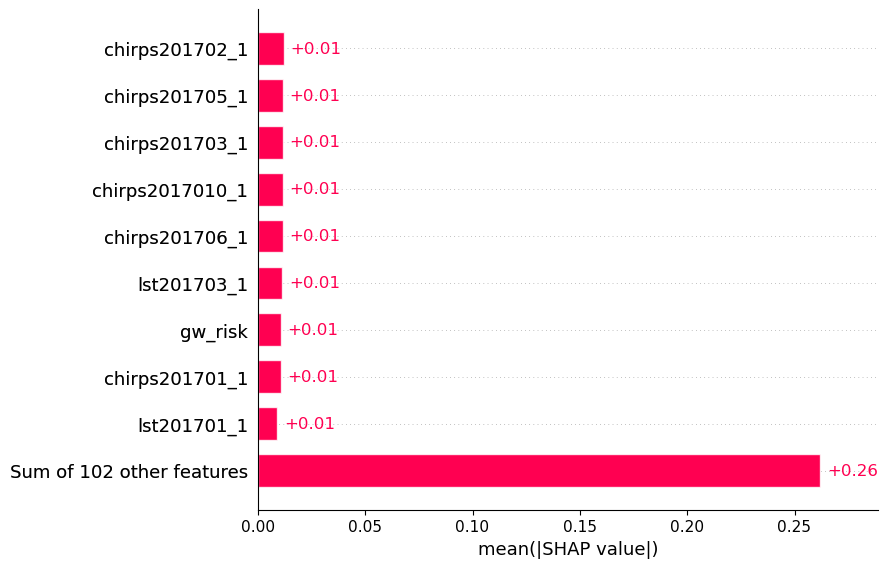

In [41]:
shap.plots.bar(best_rf_explanation[:, :, 1])

#### Instance-SHAP values vs. Feature Values

The beeswarm plot below is a visual representation of SHAP values for each feature in a machine learning model. Each point on the plot represents the SHAP value for a feature for an individual prediction. The features are listed in order of importance from top to bottom. The feature at the top (e.g., chirps201702_1) has the highest impact on model output, while the cumulative impact of the other features is shown at the bottom. The spread of the points on the x-axis represents the range of the SHAP values for each feature. Features with a wider spread have a larger variation in their impact on the model's predictions.The color of the points indicates the feature value for that observation, with blue indicating low values and red indicating high values.

Features with points that stretch further to the right have a higher positive impact on the model's prediction, while those stretching to the left have a negative impact. Features with most points clustered around the middle (near the vertical zero line) have a lower impact.

In the context of predicting siltation in small tanks, this plot helps identify which features (like specific months of chirps data or lst data) have the most influence on increasing or decreasing the predicted siltation levels. Such insights can guide targeted interventions to mitigate siltation by focusing on the most impactful factors.

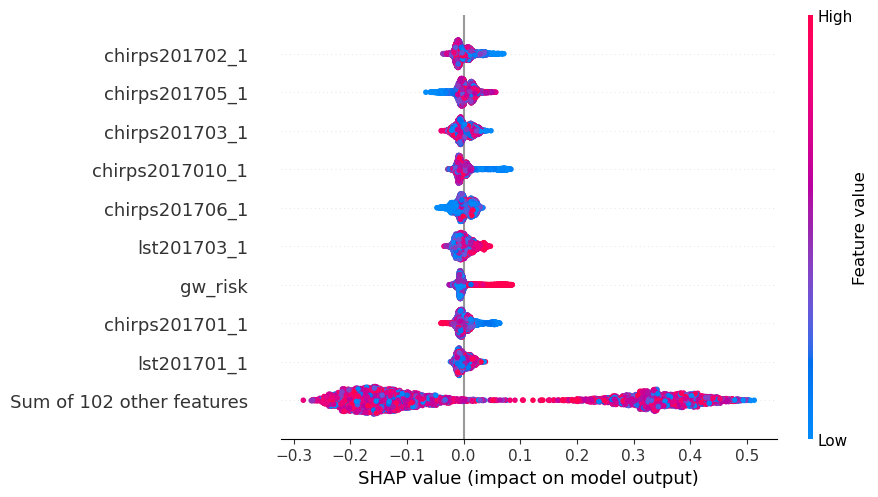

In [42]:
shap.plots.beeswarm(best_rf_explanation[:, :, 1])

#### Interaction between features and Instance-SHAP Values

The scatter plot of SHAP values visualizes the impact of a single feature (precipitation, chirps201702_1) on the model's predictions. The x-axis shows the feature's value, while the y-axis displays the corresponding SHAP value for that feature across all data points. The horizontal axis represents the actual values of the chirps201702_1 feature. The distribution of data points along this axis indicates the range of values that the feature takes in the dataset.

SHAP values on the vertical axis represent the impact of the chirps201702_1 feature on the prediction. Points above the zero line increase the prediction value (push the prediction higher), while points below decrease it (push the prediction lower).

The color scale, transitioning from blue to red, likely represents another feature's value (number of sluices). A lighter color (blue) might indicate lower values, and a darker color (red) higher values of this additional feature.

The plot also includes a histogram on the x-axis showing the density of the feature values. It appears that most values of chirps201702_1 are centered around a particular range, with some outliers towards the right.

From this plot, we can deduce that for chirps201702_1, there's a wide variation in its impact on the model's predictions, with certain values having a strong positive or negative effect. The presence of any trend or pattern could indicate how this feature interacts with the target variable. The coloring by another feature or the outcome suggests that there might be an interaction effect where the impact of chirps201702_1 on the prediction changes depending on the value of num_slu.

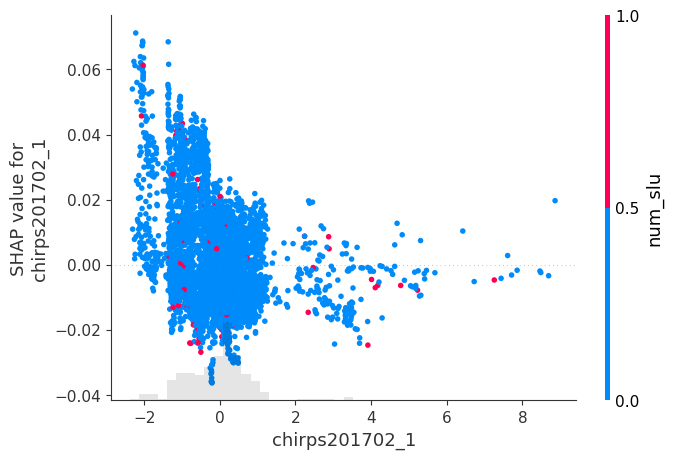

In [43]:
shap.plots.scatter(
    best_rf_explanation[:, 'chirps201702_1', 1],
    best_rf_explanation[:, 'num_slu', 1],   
)

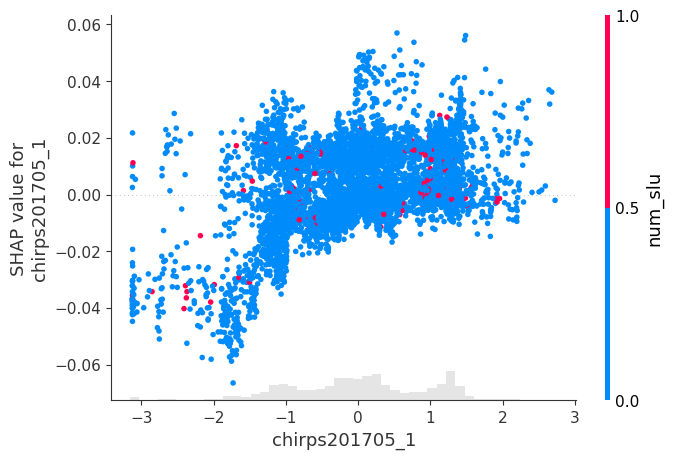

In [44]:
shap.plots.scatter(
    best_rf_explanation[:, 'chirps201705_1', 1],
    best_rf_explanation[:, 'num_slu', 1],   
)

## Prediction explaination

Investigating individual predictions with SHAP values is beneficial because it allows for the dissection of the model's decision-making process on a case-by-case basis. This granular analysis can reveal how each feature influences a particular prediction, helping to validate the model's behavior, uncover potential data issues, or identify patterns that may not be apparent from a global feature importance perspective. Such insights are invaluable for troubleshooting, understanding model reliability, and providing explanations for stakeholders on specific predictions, especially in critical applications like environmental management where each decision can have significant real-world consequences.

In [45]:
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

In [46]:
best_rf_model.predict_proba(X_test_enc)[100]

array([0.07911263, 0.59329114, 0.32759623])

In [47]:
best_rf_explainer.expected_value

array([0.33131497, 0.33409867, 0.33458636])

In [48]:
test_rf_explanation = best_rf_explainer(X_test_enc)

Examining an individual prediction with SHAP values, as depicted in the waterfall plot, provides granular insights into the contribution of each feature to that specific prediction. The plot illustrates how each feature's value pushes the model's output from the base expectation (E[f(X)])—the average model output over the dataset—toward the final prediction (f(X)), with each bar representing the incremental impact. The plot clarifies the positive or negative influence of features, like chirps201705_1 increasing the prediction score, while chirps201701_1 decreases it, enabling a detailed understanding of the model's decision-making process for a given instance.

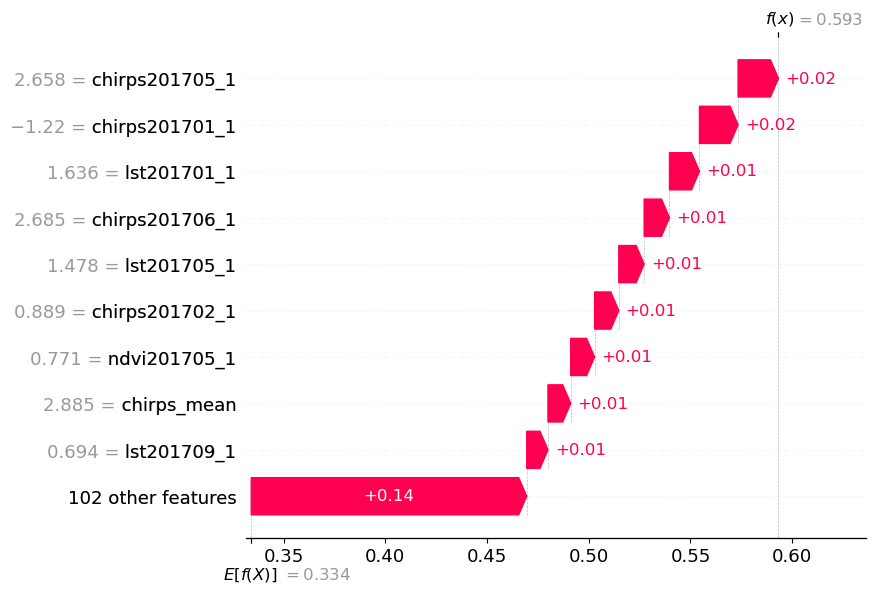

In [49]:
shap.plots.waterfall(test_rf_explanation[100, :, 1])

In [50]:
best_rf_model.predict_proba(X_test_enc)[200]

array([0.07097282, 0.28590103, 0.64312615])

This SHAP waterfall plot illustrates the contribution of individual features to a specific prediction for a single instance. Starting from the expected model output (E[f(X)] = 0.334), each bar represents a feature's SHAP value, showing how it moves the prediction away from the base value toward the final output (f(X) = 0.286).

Features with bars extending to the right (red) increase the prediction value, while those extending to the left (blue) decrease it. For example, lst201712_1 and lst201703_1 push the prediction higher, indicating a positive correlation with the target, whereas chirps2017010_1 and lst201709_1 contribute to lowering the prediction, suggesting a negative correlation. The large blue bar at the bottom indicates the cumulative impact of the remaining 102 features, which collectively decrease the prediction by a notable amount. Understanding these influences helps explain why the model predicts a lower or higher siltation level for this particular tank.

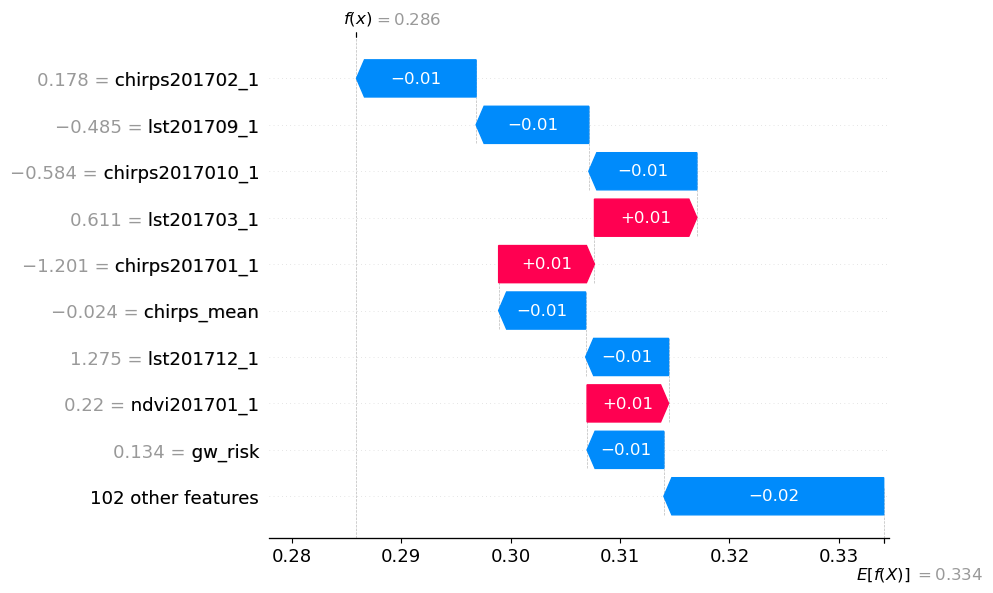

In [51]:
shap.plots.waterfall(test_rf_explanation[200, :, 1])

## Performance on test data

The final Random Forest model with tuned hyperparameters demonstrates a strong performance on the test data, achieving a macro-average F1 score of 0.709, which reflects a balanced consideration of precision and recall across all classes. The confusion matrix reveals that the model is particularly effective at predicting class 2 ("more than 3 ft" of siltation), with a high recall of 0.80 indicating that 80% of the actual class 2 instances were correctly identified. It also performs well with class 1, with a recall of 0.72. Class 0 has a lower recall of 0.58, suggesting some difficulty in identifying the least silted tanks. Overall, the precision for all classes is consistently high (around 0.72-0.74), indicating that when the model predicts a certain class, it is likely to be correct. This level of performance on the test set, particularly the high F1-scores across the classes, indicates that the model is not only accurate overall (73% accuracy) but also maintains a good balance between precision and recall, making it a reliable tool for predicting siltation levels in small tanks.

In [52]:
best_rf_model.fit(X_train_enc, y_train)

# Make predictions
y_pred = best_rf_model.predict(X_test_enc)

print(
    "Macro-average f1 score on the test set: %0.3f"
    % (f1_score(y_test, y_pred, average="macro"))
)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

Macro-average f1 score on the test set: 0.709
Confusion Matrix:
 [[151  56  54]
 [ 37 400 121]
 [ 23  88 458]]

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.58      0.64       261
           1       0.74      0.72      0.73       558
           2       0.72      0.80      0.76       569

    accuracy                           0.73      1388
   macro avg       0.72      0.70      0.71      1388
weighted avg       0.73      0.73      0.72      1388



## Deployment

Deploying the model to a dataset with missing siltation information involves a few key steps:

Data Preparation: The dataset without siltation information must be preprocessed using the same steps as the original model training dataset. This means applying the same transformations, handling missing values, scaling numeric features, and encoding categorical variables as done previously.

Model Application: The trained Random Forest model with tuned hyperparameters is then applied to the processed dataset to predict the siltation levels. Since the model has been trained to handle data similar to the training set, it can now provide predictions for new, unseen data.

Prediction and Interpretation: The model outputs a "predicted_target" for each instance in the new dataset. The prediction results show the number of tanks for each predicted siltation category: 2998 tanks are predicted to have siltation level 1 ("1-3 ft"), 2739 tanks with level 0 ("less than 1 ft"), and 1836 tanks with level 2 ("more than 3 ft").

Operational Use: These predictions can be used to prioritize maintenance and remediation efforts. For instance, tanks predicted to have a higher siltation level (level 2) may be flagged for urgent desilting operations, while those with lower levels could be scheduled for routine maintenance.

The prediction count distribution suggests that the majority of tanks fall within the "1-3 ft" siltation level, indicating a significant need for intervention in the middle range of siltation severity. By using the model's predictions, resource allocation can be optimized to address the most pressing siltation issues first, thus enhancing the efficiency and effectiveness of maintenance efforts.

In [53]:
X_deploy = pd.read_excel('data/undp_small_tanks_sendimentation_predict.xlsx')
X_deploy.head()

,map_id,tank_owner,functional,ndvi201701_1,ndvi201702_1,ndvi201703_1,ndvi201704_1,ndvi201705_1,ndvi201706_1,ndvi201707_1,...,has_2_func_sluice,has_spill,has_2_spill,silt,poly,no_neighbors,cascade,renovat,num_slu,soil
0,15,DAD,Abandoned,7687.636719,5552.469238,4618.281250,4482.211426,5620.000000,6885.631836,5545.787598,...,0,1,0,NaN,1,0.0,0.0,0.0,0,"Noncalcic Brown soils, soils on old alluvium &..."
1,16,DAD,Functioning,6913.036133,5359.130371,4990.562012,4914.244629,5465.482910,6484.871094,5265.929688,...,1,1,1,NaN,1,0.0,0.0,1.0,2,"Noncalcic Brown soils, soils on old alluvium &..."
2,17,DAD,Abandoned,7205.619141,5416.968262,4933.405762,4813.590820,5489.919434,6615.495117,5330.633789,...,0,1,0,NaN,1,0.0,0.0,0.0,0,"Noncalcic Brown soils, soils on old alluvium &..."
3,21,DAD,Functioning,7445.786621,6612.575684,6011.904297,5710.815918,5778.194336,6089.119629,5609.558105,...,1,1,0,NaN,1,1.0,0.0,1.0,2,Noncalcic Brown soils & Low Humic Gley soils; ...
4,41,DAD,Functioning,8227.513672,7937.765625,6693.825195,6578.534668,6791.583008,7627.004883,8033.291992,...,0,1,0,NaN,1,1.0,0.0,0.0,1,Alluvial soils of variable drainage and textur...


In [54]:
X_deploy_enc = pd.DataFrame(
    data=preprocessor.transform(X_deploy),
    columns=feature_names,
    index=X_deploy.index,
)

#y_deploy = pd.DataFrame(best_rf_model.predict(X_deploy_enc))

#y_deploy
X_deploy['predicted_target'] = best_rf_model.predict(X_deploy_enc)

Found unknown categories in columns [0, 1, 2, 3] during transform. These unknown categories will be encoded as all zeros


In [55]:
X_deploy['predicted_target'].value_counts()

predicted_target
1    2998
0    2739
2    1836
Name: count, dtype: int64

In [56]:
best_rf_model.predict_proba(X_deploy_enc)[100]

array([0.21875   , 0.30208333, 0.47916667])

In [57]:
deploy_rf_explanation = best_rf_explainer(X_deploy_enc)

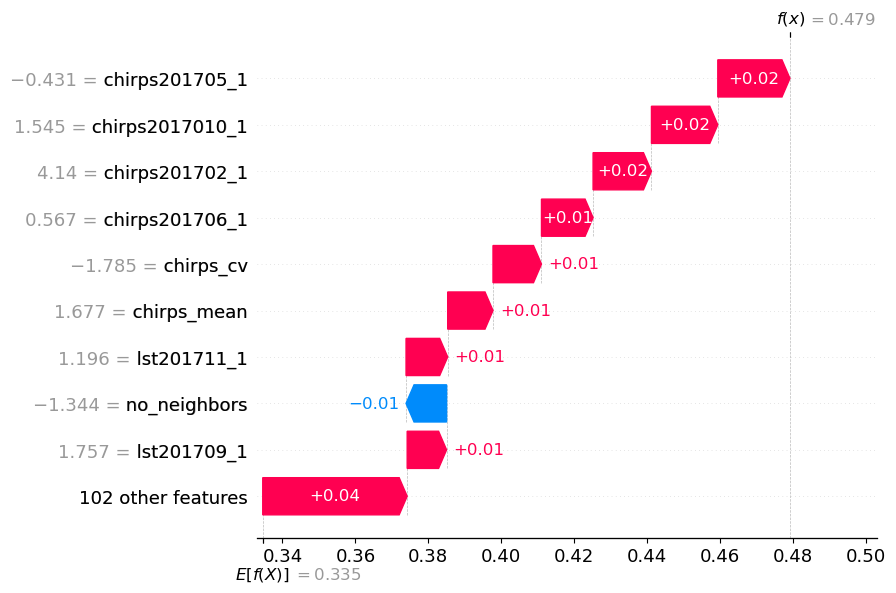

In [58]:
shap.plots.waterfall(deploy_rf_explanation[100, :, 2])

In [59]:
best_rf_model.predict_proba(X_deploy_enc)

array([[0.625     , 0.29166667, 0.08333333],
       [0.82291667, 0.125     , 0.05208333],
       [0.82291667, 0.10416667, 0.07291667],
       ...,
       [0.53480815, 0.42278621, 0.04240563],
       [0.51816279, 0.40527928, 0.07655793],
       [0.54789908, 0.3937946 , 0.05830632]])

### how confident the model is


The 3D plot displays the predicted probabilities for each class by the final Random Forest model for a deployment dataset. Each axis corresponds to the model's estimated probability for the respective siltation class: class 0 ("less than 1 ft"), class 1 ("1-3 ft"), and class 2 ("more than 3 ft").

Clusters of points close to the corners of the probability simplex (where the probability of one class is near 1) indicate higher confidence in predictions for a particular class. For example, a concentration of points near the vertex corresponding to class 2 suggests the model is highly confident about a large number of tanks having "more than 3 ft" of siltation. Conversely, points that lie towards the center of the plot, where probabilities for all classes are approximately equal, indicate lower confidence in predictions.

The color gradient, which likely represents the predicted class based on the highest probability, shows that there are distinct regions where the model is fairly confident about its predictions (intense colors) and others where the confidence is lower (regions with mixed colors).

In [61]:
import plotly.graph_objs as go
import numpy as np

# Example array of predicted probabilities
predicted_probabilities = best_rf_model.predict_proba(X_deploy_enc)

# Calculate the predicted class based on the highest probability
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# Create trace for the scatter plot
trace = go.Scatter3d(
    x=predicted_probabilities[:, 0],  # Prob. of Class 0
    y=predicted_probabilities[:, 1],  # Prob. of Class 1
    z=predicted_probabilities[:, 2],  # Prob. of Class 2
    mode='markers',
    marker=dict(
        size=5,
        color=predicted_classes,                # Color by predicted class
        colorscale='Viridis',                  # Color scale
        opacity=0.8,
        colorbar=dict(title='Predicted Class')  # Color bar for predicted class
    )
)

# Layout configuration
layout = go.Layout(
    title='3D Scatter plot of Predicted Probabilities',
    scene=dict(
        xaxis=dict(title='Prob. of Class 0 (less than 1 ft)'),
        yaxis=dict(title='Prob. of Class 1 (1-3 ft)'),
        zaxis=dict(title='Prob. of Class 2 (more than 3 ft)')
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Create figure
fig = go.Figure(data=[trace], layout=layout)

# Show figure
fig.show()
